<a href="https://colab.research.google.com/github/Vmjkom/Intro_to_nlp_2021/blob/main/Intro_to_Nlp_Anssi_Ville_Maija_Maija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Johdatus kieliteknologiaan 2021 projektityö
#Ryhmän jäsenet: Ville Komulainen, Maija Vuorio ja Anssi Arola



Ladataan annotoidut tiedostot tsv-muodossa. 
Koska sekä joy- että anger-materiaalit olivat saman nimisiä tiedostoja, tallentamisen kanssa oli ongelmia. Kummallekin materiaalille tehtiin omat kansiot mkdir-komennolla.



In [ ]:


!wget -qnc http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/dev.tsv
!wget -qnc http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/test.tsv
!wget -qnc http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/train.tsv

!mkdir anger
!mv /content/dev.tsv anger
!mv /content/test.tsv anger
!mv /content/train.tsv anger

mkdir: cannot create directory ‘anger’: File exists


In [ ]:
!wget -qnc http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv
!wget -qnc http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv
!wget -qnc http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv

!mkdir joy
!mv /content/dev.tsv joy
!mv /content/test.tsv joy
!mv /content/train.tsv joy

mkdir: cannot create directory ‘joy’: File exists


Tuodaan tarvittavat kirjastot, tehdään funktio tiedoston avaamiselle. Funktio lukee kaikki rivit ja sekoittaa ne. 

In [ ]:
import csv
import json
import random

def open_file(file):

  with open(file,"rt") as f:
    data = f.readlines()
    
  random.shuffle(data)
  return data



Tuodaan udpipe ja re (regular expressions). Re avulla voidaan etsiä tietty kirjainjono (string) tiedostosta/datasta. 

Tehdään erilaisia funktioita: avataan tiedosto, erotetaan rivit (t = tab) välilyönnillä



Siivotaan tekstiä: poistetaan merkit ja linkit






In [ ]:
!wget -qnc https://github.com/TurkuNLP/intro-to-nlp/raw/master/Data/fi.segmenter.udpipe
!pip3 install --quiet ufal.udpipe



In [ ]:
from nltk.stem.snowball import SnowballStemmer
import ufal.udpipe as udpipe
import re


#Tehdään listat tunnisteille ja teksteille. 
#Käydään kaikki rivit läpi for-loopilla, tämän jälkeen listat palautetaan
def handle_file(file):
  rivit = open(file)
  uusi = [rivi.split('\t') for rivi in rivit]

  labels = []
  texts = []
  
  for row in uusi:
    labels.append(row[0])
    texts.append(row[1])  
    
  return labels,texts

#Funktio joka kerää kaikki tarvittavat yhteen ja jota kutsutaan luokittelijaa ja vectorizeriä tehtäessä
def clean_text(text):

  model = udpipe.Model.load("fi.segmenter.udpipe")
  pipeline = udpipe.Pipeline(model, "tokenize", "none", "none", "horizontal")
  
  marks_text = [remove_marks(rivi) for rivi in text]
  #Ei käytetty lopullisessa versiossa
  stemmed_text = [stem(rivi) for rivi in marks_text]
  clean_teksti = [remove_urls(rivi) for rivi in marks_text]
  #Segmentoidaan tekstiä: käytetään aiemmin ladattua udpipe-segmenteriä, 
  #joka erottaa merkit toisistaan.
  segmented_text = [pipeline.process(text) for text in clean_teksti]
  
  return segmented_text

#Poistetaan Twitter-riveistä "mentions" eli @-merkki ja sen jälkeen tuleva nimimerkki.
#Poistetaan semanttisesti hyödyttömät väli-ja erikoismerkit (#@"+-,.*)
def remove_marks(text):
  remove_mentions = re.sub(r'@\S+',"",text)
  text = re.sub(r'([#"+-,.*]+)',"",remove_mentions)
  return text


#Poistetaan http:-linkit (S+ poistaa http: jälkeiset kirjaimet eli koko linkin)
def remove_urls(text):
  text = re.sub(r"http\S+", "", text)
  return text

#Lopussa on myös stemmatizer-funktio nltk:sta, mutta huomasimme, ettei sen käytöstä ollut hyötyä.
def stem(text):
  
  stemmer = SnowballStemmer("finnish")
  stem = " ".join(stemmer.stem(w) for w in text.split())

  return stem


Annetaan training, development sekä test-tiedostoille erilliset nimet, joy ja anger erikseen kummallekin. Yhdistimme joy- ja anger-rivit mahdollisen yhtenäisen luokittelijan vuoksi.

In [ ]:
#Joy

joy_train_labels,joy_train_texts = handle_file('joy/train.tsv')
joy_dev_labels,joy_dev_texts = handle_file('joy/dev.tsv')
joy_test_labels,joy_test_texts = handle_file('joy/test.tsv')

#Anger

anger_train_labels,anger_train_texts = handle_file('anger/train.tsv')
anger_dev_labels,anger_dev_texts = handle_file('anger/dev.tsv')
anger_test_labels,anger_test_texts = handle_file('anger/test.tsv')

In [ ]:
#yhteinen
train_labels,train_texts = joy_train_labels+anger_train_labels,joy_train_texts+anger_train_texts 
dev_labels,dev_texts = joy_dev_labels+anger_dev_labels,joy_dev_texts+anger_dev_texts
test_labels,test_texts = joy_test_labels+anger_test_labels,joy_test_texts+anger_test_texts

In [ ]:
#Tarkistetaan, että jokaiselle teksti riville on oma label

print(len(dev_labels),len(dev_texts))
print(len(train_labels),len(train_texts))
print(len(test_labels),len(test_texts))

302 302
2064 2064
594 594



Katsotaan tekstiä läpi varmuuden vuoksi ja katsotaan minkälaista tulosta clean_text funktio saa aikaiseksi.

In [ ]:
index = 1
for label,text in (list(zip(train_labels,clean_text(train_texts)))):
    print(index,label,text)
    index += 1
print("Labels",len(train_labels),"Tekstit",len(clean_text(train_texts)))

1 not-joy Haluat kännätä ja rypeä itsesäälissä

2 joy Tuntuu mukavalta päästä taas hoitotyön pariin :)

3 joy Ilo oli minun puolellani

4 not-joy Turkkilaiset kollegani suuresta Turkin kansalliskokouksesta harmittelevat samoin tätä epäkohtaa nimittäin että kukaan ei halua ilmeisesti puhua heidän kanssaan ei kansallisista hallituksista tai parlamenteista eikä myöskään lähes kaikista eurooppalaisista instituutioista

5 joy Haluan sanoa että olet tehnyt loistavaa työtä

6 joy Hyvä kun muistutit että Noin viikon uutiset ilmaantuu taas kuvioihin😊

7 not-joy Orpo ja Soini twiittaavat että hallitusyhteistyötä ei voida jatkaa

8 joy Moskova on kaunis keväällä

9 not-joy Musta ja Valkoinen haihtuvat keltaiseksi jauheeksi ja painuvat lattian alle

10 joy Itsetehdyt croissantit maistuvat ihanilta

11 not-joy Jos sinusta tulee joskus sankari lupaan olla kunnollinen ihminen

12 not-joy Miksi te juotte kylmää kahvia ?

13 not-joy Minun pitäisi käyttää sitä

14 joy Meille riittää että pelastuit Hyvä 

Päätimme käyttää CountVectorizeria sen yksinkertaisuuden vuoksi.
Luokittelijaksi valitsimme luennoilla käydyn SVM:n. 
Optimaalisten parametrien etsimisiseksi käytimme sklearn.pipelinea ja GridSearchCV-kirjastoja.
Joy- ja anger-teksteihin käytimme erillisiä GridSearch-malleja. 





In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LinearSVC()),
])
#Parametreissä varmistetaan, että tekstin isot kirjaimet pysyy, ettei menetetä semantiikkaa. 
#Vectorizerin token_pattern muutettiin, ettei hyödylliset välimerkit tai hymiöt poistuisi tekstistä. Tällä hetkellä kaikki paitsi välilyönnit tokenisoidaan.
#Luokittelija class_weight muutettiin balanced, koska datassa oli epätasapainoa positiivisten ja ei-positiivisten tunnisteiden välillä.
parameters = {
    'vect__lowercase': (False,),
    'vect__token_pattern': (r'[^\s]+',),
    'vect__ngram_range': ((1,1), (1,2), (1,3), (1,4)),
    'clf__C': (0.05, 0.005, 1, 10),
    'clf__class_weight':('balanced',)
}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search_anger = GridSearchCV(pipeline,parameters,verbose=1)


print("parameters:")


grid_search_anger.fit(clean_text(anger_train_texts),anger_train_labels)

#Tallennetaan angerille optimaalisimmat parametrit, mitkä tämä gridsearch löysi
print("Best score: %0.3f" % grid_search_anger.best_score_)
print("Best parameters for anger:")
best_parameters = grid_search_anger.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))


parameters:
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score: 0.841
Best parameters for anger:
	clf__C: 0.05
	clf__class_weight: 'balanced'
	vect__lowercase: False
	vect__ngram_range: (1, 3)
	vect__token_pattern: '[^\\s]+'


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.9s finished


In [ ]:
grid_search_joy = GridSearchCV(pipeline,parameters,verbose=1)


print("parameters:")


grid_search_joy.fit(clean_text(joy_train_texts),joy_train_labels)

#Tallennetaan joylle optimaalisimmat parametrit, mitkä tämä gridsearch löysi
print("Best score: %0.3f" % grid_search_joy.best_score_)
print("Best parameters for joy:")
best_parameters = grid_search_joy.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

parameters:
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score: 0.747
Best parameters for joy:
	clf__C: 0.05
	clf__class_weight: 'balanced'
	vect__lowercase: False
	vect__ngram_range: (1, 1)
	vect__token_pattern: '[^\\s]+'


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.1s finished


In [ ]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

joy_vectorizer=CountVectorizer(lowercase=False,token_pattern=r'[^\s]+',ngram_range=(1,1))
joy_feature_matrix_train=joy_vectorizer.fit_transform(clean_text(joy_train_texts))
joy_feature_matrix_dev=joy_vectorizer.transform(clean_text(joy_dev_texts))



In [ ]:
print("Joy features")
print(joy_vectorizer.get_feature_names()[:-10])

Joy features
['!', '&', '&virkamies', "'", '(', ')', '-', '-kirjat', '-voimalaitoksen', '0', '000', '07l', '1', '10-', '100-kerroksinen', '109', '11', '11/1978', '12', '12-litraiset', '120vuotiasta', '13-litrainen', '19', '1900-luvun', '1957-1963', '2', '2-vuotiaalle', '2/2', '20', '2004', '2009', '2010', '24', '24KinHelsinki', '25:ssa', '27', '28', '28111953', '29111959', '3', '30', '30:ssa', '32:ssa', '34:ssa', '4', '400', '5', '5/5', '500', '500tkm', '6', '69', '6:ssa', '7', '77', '9', '991962', '9995%:lle', ':', ':)', ';)', '<3', '=', '?', 'A', 'A5-audin', 'AAAH', 'AC', 'AMK-perustutkinnon', 'Aamu', 'Adam', 'Agilan', 'Agraari-', 'Ahdistelua', 'Ai', 'Aiheellinen', 'Aika', 'Aikuiset', 'Ainakin', 'Aino-Kaisa', 'Airbag', 'Aivan', 'Ajattelin', 'Ajetaan', 'Akademin', 'Al', 'Alba', 'Alex', 'Allekirjoittanut', "AlliTrygg'in", 'Allianssin', 'Ammattiyhdistysväen', 'Analyysi', 'Anna', 'Antoisaa', 'Arabella', 'Ari', 'Arto', 'Asiallisesti', 'Ati', 'Atlantiksen', 'Atom', 'Atorox-palkinnon', 'Atr

In [ ]:

anger_vectorizer=CountVectorizer(lowercase=False,token_pattern=r'[^\s]+',ngram_range=(1,3))
anger_feature_matrix_train=anger_vectorizer.fit_transform(clean_text(anger_train_texts))
anger_feature_matrix_dev=anger_vectorizer.transform(clean_text(anger_dev_texts))

print("Anger features:")
print(anger_vectorizer.get_feature_names()[:-10])



Anger features:
['!', '! !', '! ! !', '! ?', '! ? !', '! EVSlive', '! Ja', '! Ja ajotapaasi', '! Ja viskinkatkuista', '! Oksettavaa', '! Söin', '! Söin burriton', '! Tuki', '! Tuki suusi', '! Vauhtia', '! Vauhtia !', '! grrrrrr', '! terveydenhuolto', '! terveydenhuolto terveys', '%', '% näppäimistä', '% näppäimistä sijaitsee', '&', '& Eepi', '& Eepi Boloks', '& SKM', '& SPICY', '& SPICY BURGER', '& ärsyyntyneen', '& ärsyyntyneen näköisenä', '&gt', '&gt ;', '&gt ; Ratkaisun', '&virkamies', '&virkamies vs', '&virkamies vs yksityishenkilö', "'", "' Heität", "' Heität kuin", "' isä", "' isä sanoi", "' mitä", "' mitä jos", "' sta", "' sta sopiva", '(', '( 10', '( 10 )', '( 7', '( 7 )', '( 8', '( 8 joulukuuta', '( Emme', '( Emme ehtineet', '( Heimo', '( Heimo Kallio', '( Jukka', '( Jukka Martinkari', '( Kalervo', '( Kalervo Toivonen', '( Kansan', '( Kansan Uutiset', '( Modest', '( Modest Savtschenko', '( Olavi', '( Olavi Veistäjä', '( Päivän', '( Päivän Sanomat', '( Sillä', '( Sillä vaikka',

In [ ]:
import sklearn.svm

anger_classifier=sklearn.svm.LinearSVC(C=0.05,class_weight='balanced')
anger_classifier.fit(anger_feature_matrix_train,anger_train_labels)

joy_classifier=sklearn.svm.LinearSVC(C=0.05,class_weight='balanced')
joy_classifier.fit(joy_feature_matrix_train,joy_train_labels)

LinearSVC(C=0.05, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Testataan, miten luokittelijat oppivat train- ja development-datan. 

In [ ]:

print("DEV_JOY",joy_classifier.score(joy_feature_matrix_dev,joy_dev_labels))
print("TRAIN_JOY",joy_classifier.score(joy_feature_matrix_train,joy_train_labels))


print("DEV_ANGER",anger_classifier.score(anger_feature_matrix_dev,anger_dev_labels))
print("TRAIN_ANGER",anger_classifier.score(anger_feature_matrix_train,anger_train_labels))

DEV_JOY 0.7103448275862069
TRAIN_JOY 0.9750778816199377
DEV_ANGER 0.8853503184713376
TRAIN_ANGER 0.9981834695731153


Joy-luokittelija suoriutui huomattavasti huonommin kuin anger-luokittelija.
Tehdään ominaisuus matriisi testi datalle.
Lopuksi testataan miten luokittelijat suoriutuvat ennennäkemättömän testidatan edessä.

In [ ]:
joy_feature_matrix_test=joy_vectorizer.transform(clean_text(joy_test_texts))
anger_feature_matrix_test=anger_vectorizer.transform(clean_text(anger_test_texts))


Testidatan tulosprosentti.

In [ ]:
print("TEST_JOY",joy_classifier.score(joy_feature_matrix_test,joy_test_labels))



print("TEST_ANGER",anger_classifier.score(anger_feature_matrix_test,anger_test_labels))

TEST_JOY 0.7877697841726619
TEST_ANGER 0.8544303797468354


Jälleen nähdään, että joy-luokittelija suoriutui hieman huonommin.
Nyt katsotaan, minkälaisia kaikista voimakkaimmat sanat ovat. Tämä tehdään katsomalla niiden painoja.

In [ ]:
index2feature_anger={}
for feature_anger,idx in anger_vectorizer.vocabulary_.items():
    assert idx not in index2feature_anger
    index2feature_anger[idx]=feature_anger

index2feature_joy={}

for feature_joy,idx in joy_vectorizer.vocabulary_.items():
    assert idx not in index2feature_joy
    index2feature_joy[idx]=feature_joy

In [ ]:
import numpy

most_angry = []
most_joy = []

indices_angry=numpy.argsort(anger_classifier.coef_[0])
indices_joy=numpy.argsort(joy_classifier.coef_[0])

for idx in indices_angry[:30]:
    print(index2feature_anger[idx])
    most_angry.append(index2feature_anger[idx])
print("-------------------------------")
for idx in indices_joy[:30]: 
    print(index2feature_joy[idx])
    most_joy.append(index2feature_joy[idx])


!
tätä
kusipää
vihaan
Ärysttävää
hiton
Mitä
paskaakaan
tule
?
Vihaan
Minä
olet
Kuulkaahan nyt
Kuulkaahan
” Perkele
helvetti
saatana
sinut
tai
paska
Piru vie
Piru
ole mitään
paska jätkä
jätkä
hyi
hyi saatana
Perkele
Se ei
-------------------------------
olet
!
hyvä
mukavaa
mukava
hieno
kaunis
On
hienoa
Mukavaa
oli
ikinä
hauskaa
Hyvä
nähdä
ihanaa
iloinen
Olen
Eikö
ihana
todella
päivä
tavata
rakastan
minut
olekin
hyvin
:)
hyvää
Se


Visualisoinnin työvälineeksi valitsimme WordCloud-kirjaston, jossa näkyy kaikista voimakkaimpia sanoja.

In [ ]:
from wordcloud import  WordCloud

Stopwords  = ("Nothing")

wordcloud_angry = WordCloud(width = 2000, height = 2000,
                            background_color ='black',
                            stopwords = Stopwords,
                            min_font_size = 20,
                            regexp=r'[^\s]+').generate(" ".join(most_angry))

wordcloud_joy = WordCloud(width = 2000, height = 2000,
                            background_color ='black',
                            stopwords = Stopwords,
                            min_font_size = 20,
                            regexp=r'[^\s]+').generate(" ".join(most_joy))



Angriest words in anger data


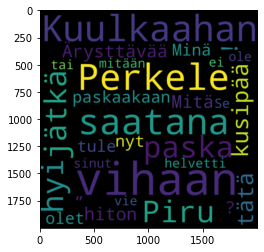


Most joyful words in joy data


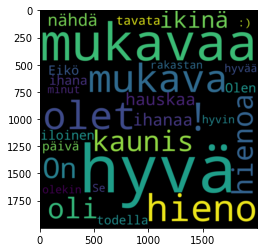

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud_angry, interpolation='bilinear')
print("Angriest words in anger data")
plt.show()
print()
plt.imshow(wordcloud_joy, interpolation='bilinear')
print("Most joyful words in joy data")
plt.show()

Milestone 3. Error analysis

Lopputulos mielestämme tyydyttävä, ottaen huomioon sen, että dataa oli melko vähän ja luokittelija on vanhanaikainen SVM. Anger-luokittelija suoriutui joy-luokittelijaa paremmin, mutta on vaikea sanoa miksi näin on. Tulos olisi ollut parempi, jos dataa olisi ollut enemmän; molemmissa dev-tiedostoissa dataa vain vajaat 100 riviä. Kaikkein optimaalisimman tuloksen saamiseksi, olisimme käyttäneet jotakin neuroverkkojärjestelmää. 

Uskomme, että lemmatizer olisi ollut tekstin siivoamisvaiheessa hyödyksi, mutta sen toteuttamisen opettelu osoittautui liian aikaavieväksi. Ylipäänsä tekstin siivoaminen oli ongelmallista, kuten anger-datassa oli merkkejä, jotka jäivät siivoamisen jälkeen tekstiin.

Ryhmä kokoontui viikottain Zoomiin, jossa työstimme projektia yhdessä yleensä yhden ihmisen jakaessa näyttöään. Tapaamisen lopussa suunnittelimme seuraavat tehtävät seuraavaa tapaamista varten. Ryhmä koostui kahdesta kielitieteen opiskelijasta (Maija, Anssi) ja yhdestä tietojenkäsittelytieteen opiskelijasta (Ville). Siten suurin osa tehtävistä tehtiin Villen johdolla ja hänen tietämyksellään. Tekstit hoituivat Maijan ja Anssin puolesta, ja he olivat aktiivisesti mukana kokonaisvaltaisesti työnteossa. Kaikki ryhmän jäsenet osallistuivat kaikkiin tapaamisiin. Alkuperäisessä ryhmässä oli neljäs henkilö, joka jättäytyi projektista pois aikataulukiireiden vuoksi.
